# Test 1: Basic SWB2 options and Thornthwaite-Mather water budget

This test combines the most commonly used SWB2 program options and completes a model run using tabular precipitation and air tempterature inputs. The output is compared to the same calculations made using a simple Python version of the same algorithms. This test also provides a check on the following functionality:

1. Partitioning of gross precipitation into 'rainfall' and 'snowfall' fractions;
2. Temperature index-based snowmelt

For this test, a curve number of '0' is used in the SWB run, essentially ensuring that there is never any runoff calculated in SWB. This is done to make the initial comparison to the Thornthwaite-Mather soil-moisture-retention tables easier to understand. The only active sources of water are rainfall and snowmelt; the sinks are actual evapotranspiration and net infiltration. 

The first half of this notebook may be skipped unless one is interested in the details of how the various model runs are set up. Basically, a simple SWB2 model is executed, followed by a set of Python implementations of SWB2. The results are compared in the last half of this notebook.

## Test setup

In [1]:
# high-level imports
import pandas as pd
import matplotlib.pyplot as plt
import pathlib as pl
import sys
import subprocess

#### Define paths to swb2 executable and working/input data directories

In [2]:
# define working directories for use in making a forward run of SWB2
base_dir = str(pl.Path.cwd().parent)
python_script_dir = pl.Path.cwd().parent / 'python'
swb_work_dir = pl.Path.cwd().parent / 'swb_work'
logfile_dir = pl.Path.cwd().parent / 'logfiles'
test_data_dir = pl.Path.cwd().parent / 'test_data'
tm_table_file = test_data_dir / 'Thornthwaite_soil_moisture_retention_tables__millimeters.csv'
output_dir = pl.Path.cwd().parent / 'output'
swb2_executable = str(pl.Path.cwd().parent / 'bin' /'swb2.exe')
sys.path.append(str(python_script_dir))

from swb_cell import SWBCell
import run_management as rm

#### Read in Thornthwaite-Mather soil moisture retention table

In [3]:
tm_soil_moisture_retention_df = pd.read_csv(tm_table_file)

#### Remove and replace working directories for swb2 run

In [4]:
rm.destroy_model_work_output_and_logfile_dirs(base_dir=base_dir,
                                              swb_work_dir=swb_work_dir,
                                              logfile_dir=logfile_dir,
                                              output_dir=output_dir)
rm.create_model_work_output_and_logfile_dirs(base_dir=base_dir,
                                             swb_work_dir=swb_work_dir,
                                             logfile_dir=logfile_dir,
                                             output_dir=output_dir)


#### Make a new swb2 model run for a single cell example

In the following step, a new swb2 model run is started using a pre-configured swb control file. The swb model contains a single cell. Daily weather data is a table of precipitation and tmax/tmin values. The test case is centered on the airport at Kenai, Alaska.

In [5]:
dry_run = False
lookup_dir_arg_text = f"--lookup_dir={str(test_data_dir)}"
weather_data_dir_arg_text = f"--weather_data_dir={str(test_data_dir)}"
output_dir_arg_text = f"--output_dir={str(output_dir)}"
logfile_dir_arg_text = f"--logfile_dir={str(logfile_dir)}"
control_file_path = str(test_data_dir / 'swb_control_file_kenai.ctl')
output_prefix = '--output_prefix=swb_kenai_'

swb_arg_text = [swb2_executable, output_dir_arg_text, lookup_dir_arg_text, weather_data_dir_arg_text, output_prefix, logfile_dir_arg_text, control_file_path]

f = open("stdout.txt", "w")

if not dry_run:
  with rm.cd(swb_work_dir):
#    p = subprocess.Popen(swb_arg_text, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    p = subprocess.Popen(swb_arg_text, stdout=f, stderr=subprocess.DEVNULL)
    p.wait()

#### Read in swb2 model results

In [6]:
swb_df = pd.read_csv(pl.Path(output_dir, 'SWB2_variable_values__Kenai_Airpt__col_1__row_1__x_150393__y_1179331.csv'))
# eliminate pesky spaces around column names
swb_df.columns = swb_df.columns.str.replace(' ', '')
swb_df.columns

Index(['date', 'month', 'day', 'year', 'landuse_code', 'landuse_index',
       'soil_group', 'num_upslope_connections', 'sum_upslope_cells',
       'solution_order', 'cell_index', 'target_index', 'awc', 'latitude',
       'reference_ET0', 'actual_ET', 'curve_num_adj', 'gross_precip', 'inflow',
       'runon', 'runoff', 'outflow', 'infiltration', 'snowfall',
       'potential_snowmelt', 'snowmelt', 'interception', 'rainfall',
       'net_rainfall', 'monthly_gross_precip', 'monthly_runoff',
       'interception_storage', 'tmax', 'tmin', 'tmean', 'snow_storage',
       'soil_storage', 'soil_storage_max', 'evaporable_water_storage',
       'evaporable_water_deficit', 'delta_soil_storage',
       'soil_moisture_deficit', 'surface_storage', 'surface_storage_excess',
       'surface_storage_max', 'net_infiltration', 'rejected_net_infiltration',
       'fog', 'irrigation', 'gdd', 'runoff_outside', 'pervious_fraction',
       'storm_drain_capture', 'canopy_cover_fraction', 'crop_coefficient_kcb

#### Convert swb Imperial units to metric

In [7]:
swb_df['tminf'] = swb_df.loc[:,'tmin']
swb_df['tmaxf'] = swb_df.loc[:,'tmax']
swb_df['tmeanf'] = swb_df.loc[:,'tmean']
swb_df.loc[:,'tmin'] = (swb_df.loc[:,'tmin'] - 32) / 1.8
swb_df.loc[:,'tmax'] = (swb_df.loc[:,'tmax'] - 32) / 1.8
swb_df.loc[:,'tmean'] = (swb_df.loc[:,'tmean'] - 32) / 1.8
swb_df.loc[:,'gross_precip'] = swb_df.loc[:,'gross_precip'] * 25.4
swb_df.loc[:,'rainfall'] = swb_df.loc[:,'rainfall'] * 25.4
swb_df.loc[:,'actual_ET'] = swb_df.loc[:,'actual_ET'] * 25.4
swb_df.loc[:,'reference_ET0'] = swb_df.loc[:,'reference_ET0'] * 25.4
swb_df.loc[:,'soil_storage'] = swb_df.loc[:,'soil_storage'] * 25.4
swb_df.loc[:,'snow_storage'] = swb_df.loc[:,'snow_storage'] * 25.4
swb_df.loc[:,'snowfall'] = swb_df.loc[:,'snowfall'] * 25.4
swb_df.loc[:,'snowmelt'] = swb_df.loc[:,'snowmelt'] * 25.4
swb_df.loc[:,'net_infiltration'] = swb_df.loc[:,'net_infiltration'] * 25.4
swb_df.loc[:,'infiltration'] = swb_df.loc[:,'infiltration'] * 25.4

swb_df['date'] = pd.to_datetime(swb_df['date'])

#### Create a Python version of a swb2 cell

In [8]:
# swb2 still uses Imperial units (inches and feet); the Python code expects metric units (mm and m).
# The example control file we're using for swb2 specifies 3.6 inches/foot for the available water capacity.
# 3.6 inches per foot equals 300 mm/m. The rooting depth is specified in the swb2 lookup table as 1.6404 feet, 
# or 1.6404 ft / 3.2808 ft/m = 0.5 m
mycell_exp = SWBCell(latitude=60.57154, available_water_capacity=300., rooting_depth=1.0, calculation_method='tm_exp')

mycell_tab = SWBCell(latitude=60.57154, available_water_capacity=300., rooting_depth=1.0, calculation_method='tm_table',
                    thornthwaite_mather_df=tm_soil_moisture_retention_df)

mycell_eqns = SWBCell(latitude=60.57154, available_water_capacity=300., rooting_depth=1.0, calculation_method='tm_eqns')

Spurious LaTeX math example here

$$
f(x) = \int_{-\infty}^{\infty} e^{-x^2} dx
$$


#### Initialize Python versions of swb

In [9]:
mycell_exp.init_swb_cell()
mycell_tab.init_swb_cell()
mycell_eqns.init_swb_cell()

#### Iterate and solve the water budget in Python over the date range contained in the swb2 output file
There are three Python versions. The first uses an exponential decay function to approximate the Thornthwaite-Mather (TM) soil moisture retention tables. The second version actually looks up the TM table values directly; the third method uses a set of fitted equations to interpolate between table values.

In [10]:
for index, row in swb_df.iterrows():
    year = int(row['year'])
    month = int(row['month'])
    day = int(row['day'])
    # exponential decay to approximate TM
    mycell_exp.calc_cell_water_budget(year, month, day,
                                      row['tmin'],row['tmax'],row['tmean'],row['gross_precip'])
    mycell_exp.variables_todict()
    # TM table values read in directly
    mycell_tab.calc_cell_water_budget(year, month, day,
                                      row['tmin'],row['tmax'],row['tmean'],row['gross_precip'])
    mycell_tab.variables_todict()
    # TM tables approximated by fitted equations to interpolate between table values
    mycell_eqns.calc_cell_water_budget(year, month, day,
                                       row['tmin'],row['tmax'],row['tmean'],row['gross_precip'])
    mycell_eqns.variables_todict()
    print(f"making calculation for {year}-{month}-{day}")

making calculation for 1967-1-1
making calculation for 1967-1-2
making calculation for 1967-1-3
making calculation for 1967-1-4
making calculation for 1967-1-5
making calculation for 1967-1-6
making calculation for 1967-1-7
making calculation for 1967-1-8
making calculation for 1967-1-9
making calculation for 1967-1-10
making calculation for 1967-1-11
making calculation for 1967-1-12
making calculation for 1967-1-13
making calculation for 1967-1-14
making calculation for 1967-1-15
making calculation for 1967-1-16
making calculation for 1967-1-17
making calculation for 1967-1-18
making calculation for 1967-1-19
making calculation for 1967-1-20
making calculation for 1967-1-21
making calculation for 1967-1-22
making calculation for 1967-1-23
making calculation for 1967-1-24
making calculation for 1967-1-25
making calculation for 1967-1-26
making calculation for 1967-1-27
making calculation for 1967-1-28
making calculation for 1967-1-29
making calculation for 1967-1-30
making calculation 

#### Convert the output dictionaries to dataframes

In [11]:
mycell_exp.convert_dict_to_df()
py_exp_df = mycell_exp.output_df.copy()
py_exp_df.loc[:,'date'] = pd.to_datetime(py_exp_df['date'])

In [12]:
mycell_tab.convert_dict_to_df()
py_tab_df = mycell_tab.output_df.copy()
py_tab_df.loc[:,'date'] = pd.to_datetime(py_tab_df['date'])

In [13]:
mycell_eqns.convert_dict_to_df()
py_eqns_df = mycell_eqns.output_df.copy()
py_eqns_df.loc[:,'date'] = pd.to_datetime(py_eqns_df['date'])

#### Merge the swb and python model outputs into a single dataframe

In [14]:
df = pd.merge(left=py_exp_df, right=py_tab_df, on='date', suffixes=('_e','_t'))
df = pd.merge(left=df, right=py_eqns_df, on='date', suffixes=(None,'_q'))
df = pd.merge(left=df, right=swb_df, on='date', suffixes=(None, '_s'))
display(df.columns.to_list())

['date',
 'previous_soil_storage_e',
 'soil_storage_e',
 'rainfall_e',
 'snow_storage_e',
 'snowfall_e',
 'snowmelt_e',
 'pet_e',
 'p_minus_pet_e',
 'aet_e',
 'net_infiltration_e',
 'apwl_e',
 'previous_soil_storage_t',
 'soil_storage_t',
 'rainfall_t',
 'snow_storage_t',
 'snowfall_t',
 'snowmelt_t',
 'pet_t',
 'p_minus_pet_t',
 'aet_t',
 'net_infiltration_t',
 'apwl_t',
 'previous_soil_storage',
 'soil_storage',
 'rainfall',
 'snow_storage',
 'snowfall',
 'snowmelt',
 'pet',
 'p_minus_pet',
 'aet',
 'net_infiltration',
 'apwl',
 'month',
 'day',
 'year',
 'landuse_code',
 'landuse_index',
 'soil_group',
 'num_upslope_connections',
 'sum_upslope_cells',
 'solution_order',
 'cell_index',
 'target_index',
 'awc',
 'latitude',
 'reference_ET0',
 'actual_ET',
 'curve_num_adj',
 'gross_precip',
 'inflow',
 'runon',
 'runoff',
 'outflow',
 'infiltration',
 'snowfall_s',
 'potential_snowmelt',
 'snowmelt_s',
 'interception',
 'rainfall_s',
 'net_rainfall',
 'monthly_gross_precip',
 'monthly_

In [15]:
# estimate 'P minus PET' for swb
df['p_minus_pet'] = (df['snowmelt'] + df['rainfall'] - df['crop_etc']) * 25.4

## Test comparisons

In [16]:
my_subset = df[(df['date'] > "1967-01-01") & (df['date'] < "1968-12-31")]
#my_subset[['date','tmin','tmax','tmean','tminf','tmaxf','tmeanf','gross_precip','soil_storage_s','soil_storage_p',
#           'infiltration', 'p_minus_pet_s','p_minus_pet',
#           'reference_ET0','pet','actual_ET','aet']]
df = my_subset

### SNOWFALL

SWB2 uses the same empirical relations as were used in Dripps (2003) and Dripps and Bradbury (2007) to partition gross precipitation into 'rainfall' and 'snowfall'.


$$
snow: T_{mean} - \frac{1}{3}(T_{max} - T_{min}) \leq 32
$$
$$
rain: T_{mean} - \frac{1}{3}(T_{max} - T_{min}) > 32
$$

where:

$T_{mean}$ is the mean daily air temperature, in degrees Fahrenheit,

$T_{max}$ is the maximum daily air temperature, in degrees Fahrenheit,

$T_{mean}$ is the minimum daily air temperature, in degrees Fahrenheit.


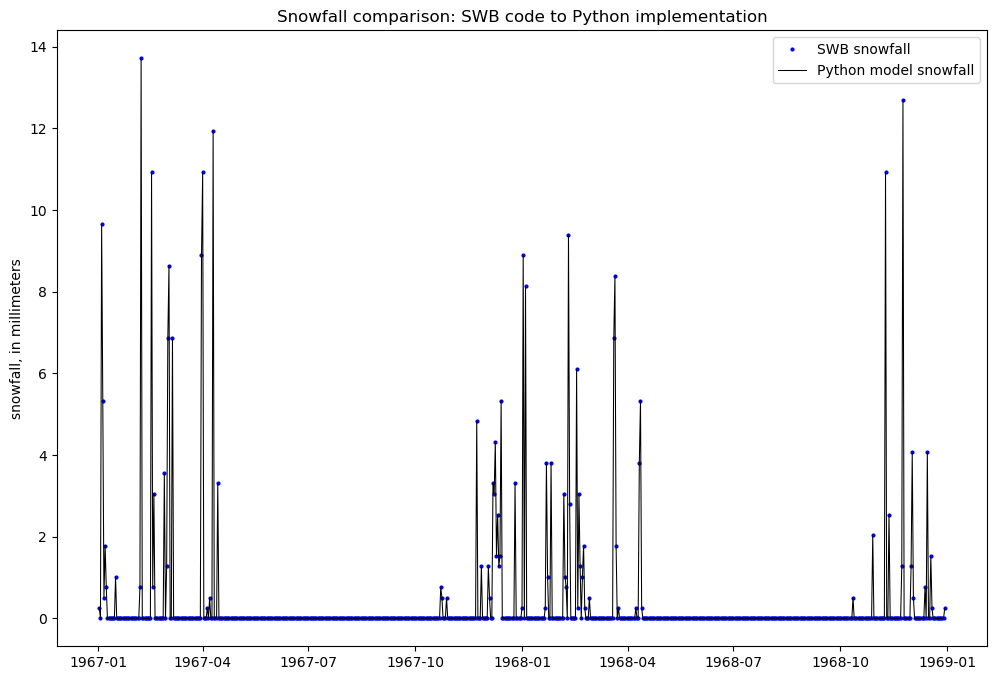

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['snowfall'], marker='.', linestyle=' ', color='blue', markersize=4, label='SWB snowfall')
ax.plot(df['date'], df['snowfall_e'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model snowfall')
ax.set_ylabel('snowfall, in millimeters')
ax.set_title('Snowfall comparison: SWB code to Python implementation')
ax.legend()

### SNOWMELT

SWB2 uses the same empirical relations as were used in Dripps (2003) and Dripps and Bradbury (2007) to estimate the potential snowmelt from accumulated snowpack on a given day. Actual snowmelt is limited by the amount of moisture stored in the snow storage reservoir.


$$
potential\, snowmelt = 0.059 \cdot (T_{max} - 32)
$$

where:

$T_{max}$ is the maximum daily air temperature, in degrees Fahrenheit.

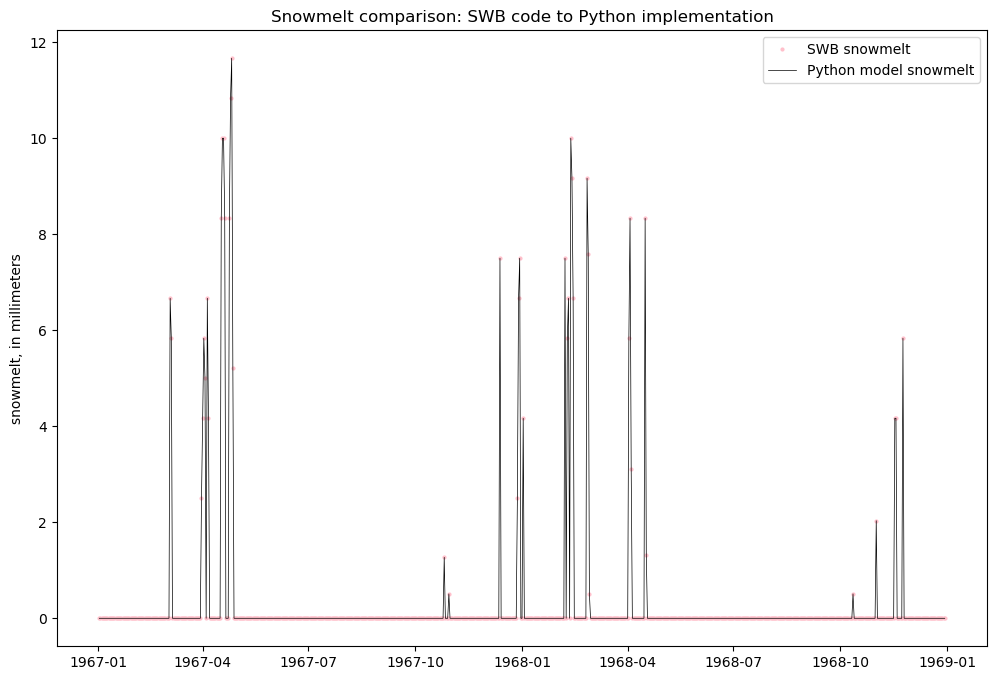

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['snowmelt'], marker='.', linestyle=' ', color='pink', markersize=4, label='SWB snowmelt')
ax.plot(df['date'], df['snowmelt_e'], marker=' ', linestyle='-', 
        color='black', linewidth=0.5, label='Python model snowmelt')
ax.set_ylabel('snowmelt, in millimeters')
ax.set_title('Snowmelt comparison: SWB code to Python implementation')
ax.legend()

### SNOW STORAGE

Snow storage evolves over the course of a run, with the snowfall and snowmelt calculated as noted above. If the snowfall and snowmelt components are consistent between the SWB code and the Python code, the snow storage evolution over time should be consistent as well.

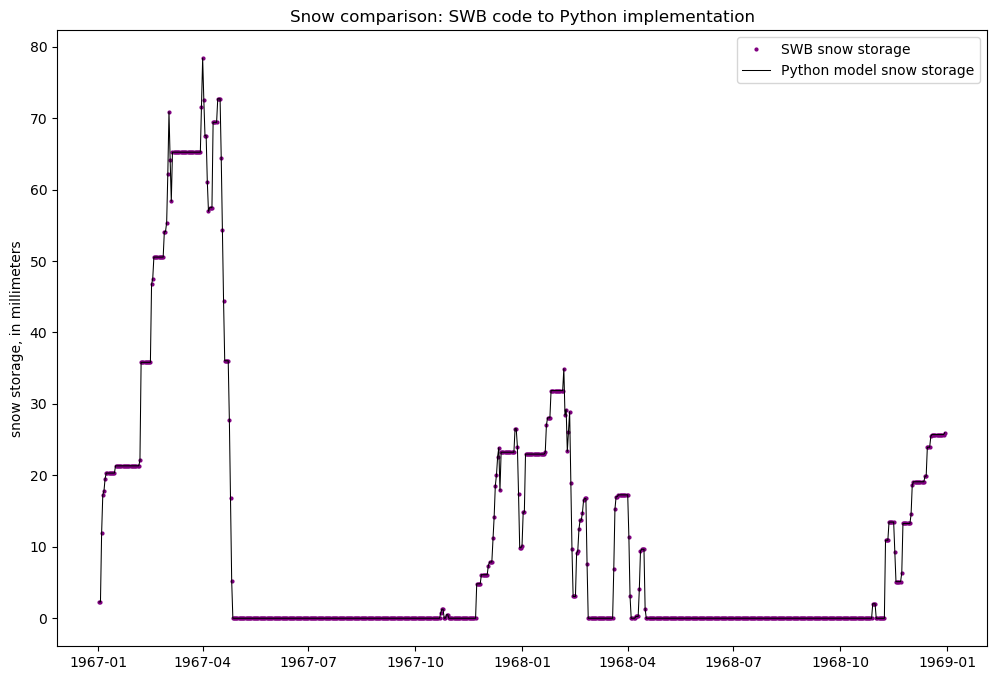

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['snow_storage'], marker='.', linestyle=' ', color='purple', markersize=4, label='SWB snow storage')
ax.plot(df['date'], df['snow_storage_e'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model snow storage')
ax.set_ylabel('snow storage, in millimeters')
ax.set_title('Snow comparison: SWB code to Python implementation')
ax.legend()

### SOIL STORAGE / SOIL-MOISTURE RETENTION

The first versions of the SWB code included extensive routines to read in and interpolate the tables of soil-moisture-retention data included in the appendixes of Thornthwaire and Mather (1957). After working with the tables for some time, it became clear that the values are simply tabulated values calculated from an exponential relation: 

$$
S_i = S_{i-1} \,e^\frac{-(PE_i - P_i)}{\phi}
$$

where:

$S_i$ is the soil moisture on day $i$, in millimeters

$S_{i-1}$ is the soil moisture on day $i-1$, in millimeters

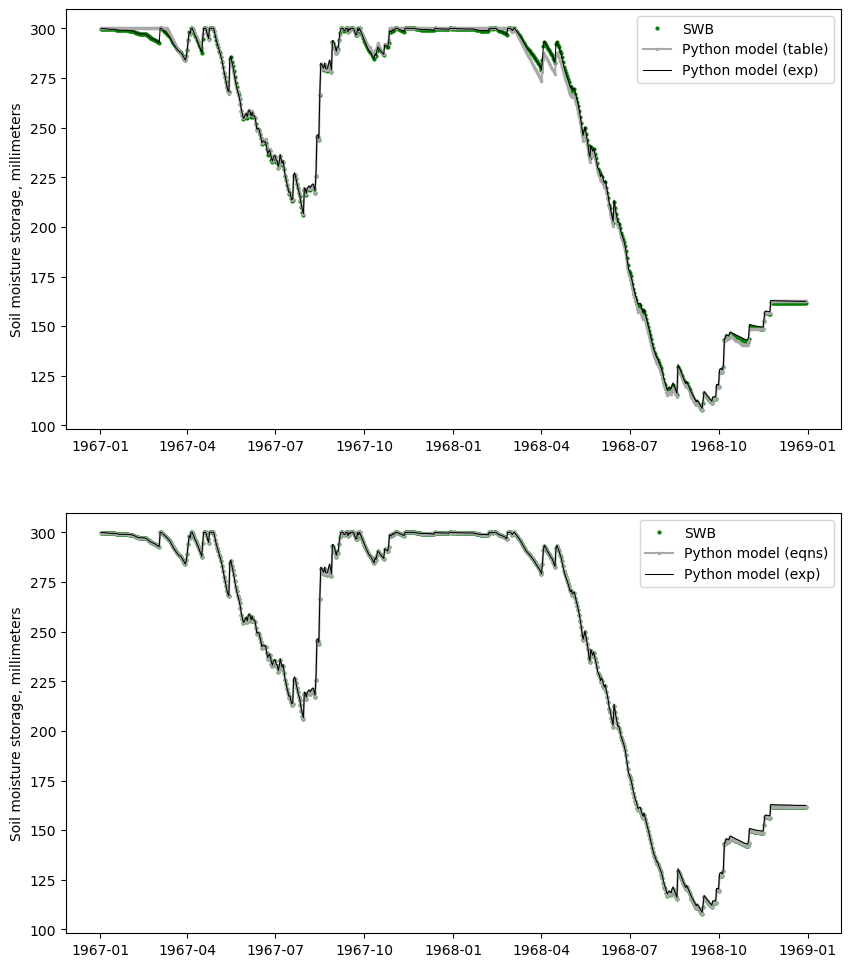

In [21]:
fig = plt.figure(figsize=(10, 12))

ax = fig.add_subplot(2,1,1)
ax.plot(df['date'], df['soil_storage'], marker='.', linestyle=' ', color='green', markersize=4, label='SWB')
ax.plot(df['date'], df['soil_storage_t'], marker='.', linestyle='-', color='darkgray', markersize=3, label='Python model (table)')
ax.plot(df['date'], df['soil_storage_e'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model (exp)')
ax.set_ylabel('Soil moisture storage, millimeters')
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(df['date'], df['soil_storage'], marker='.', linestyle=' ', color='green', markersize=4, label='SWB')
ax.plot(df['date'], df['soil_storage'], marker='.', linestyle='-', color='darkgray', markersize=3, label='Python model (eqns)')
ax.plot(df['date'], df['soil_storage_e'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model (exp)')
ax.set_ylabel('Soil moisture storage, millimeters')
ax.legend()


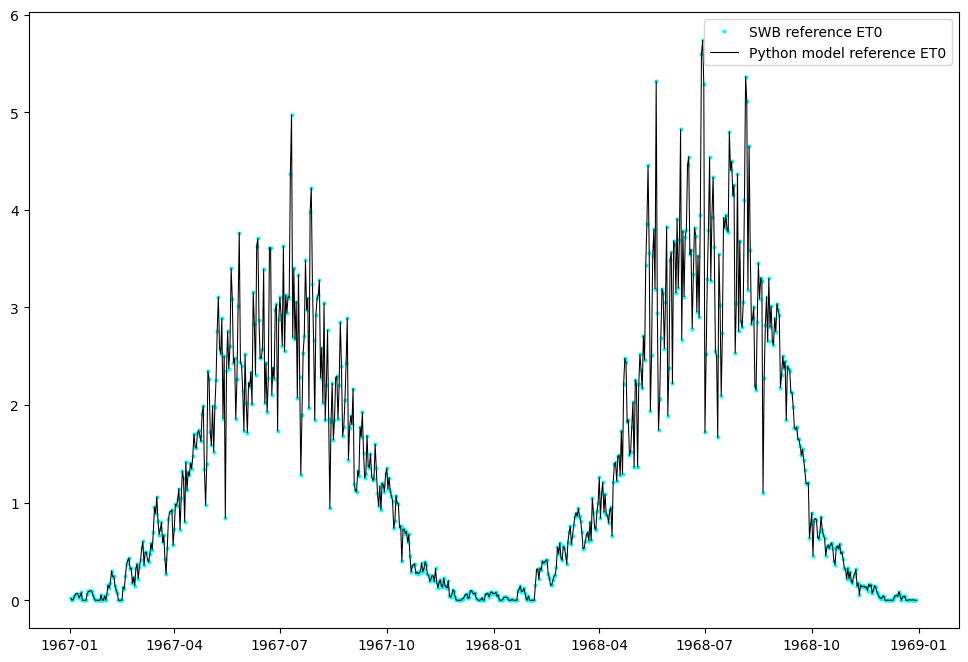

In [22]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['reference_ET0'], marker='.', linestyle=' ', color='cyan', markersize=4, label='SWB reference ET0')
ax.plot(df['date'], df['pet_e'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model reference ET0')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['apwl_t'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model APWL')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['reference_ET0'], linestyle='-.', marker='.', color='black', linewidth=.3, label='SWB refET')
ax.plot(df['date'], df['pet_t'], linestyle='-.', color='purple', linewidth=.3, label='Python pet')
ax.plot(df['date'], df['actual_ET'], marker='.', linestyle=' ', color='green', markersize=5, label='SWB actual ET')
ax.plot(df['date'], df['aet_t'], marker='.', linestyle='-', color='darkgray', markersize=3, label='Python model (table) actual et')
ax.plot(df['date'], df['aet_e'], marker=' ', linestyle='-', 
        color='brown', linewidth=0.75, label='Python model (exp) actual et')
ax.set_ylabel('Evapotranspiration, millimeters')
ax.legend()
ax2 = ax.twinx()
ax2.plot(df['date'], df['rainfall'], color='blue', linewidth=0.4)
ax2.plot(df['date'], df['snowmelt'], color='red', linewidth=0.4 )


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['net_infiltration'], marker='.', linestyle=' ', color='orange', markersize=4, label='SWB net infiltration')
ax.plot(df['date'], df['net_infiltration_t'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model net infiltration (table)')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['actual_ET'], marker='.', linestyle=' ', color='green', markersize=4, label='SWB actual ET')
ax.plot(df['date'], df['aet_t'], marker=' ', linestyle='-', color='black',
        linewidth=0.75, label='Python model actual ET')
ax.legend()
ax2 = ax.twinx()
ax2.plot(df['date'], df['rainfall'], color='blue', linewidth=0.4)
ax2.plot(df['date'], df['snowmelt'], color='red', linewidth=0.4 )